In [ ]:
import time
import math
import torch
import sys

sys.path.insert(0, "SparseRecovery")
import algorithms.OMP_reconstruction as OMP

dtype = torch.float
device_id = "cuda"

In [12]:
def generate_data(N, M, D, dtype=torch.float, device="cuda"):
    # sample D-dimensional array of random Tchebychev points in [-1,1]^D
    samples = math.pi * (
        torch.rand(N, D, dtype=dtype, device=device, requires_grad=False) - 0.5
    )
    samples = samples.tan()
    samples = samples / torch.sqrt(samples**2 + 1)

    # define D-dimensional array of indices in [0, R]^D based on hyperbolic cross density
    def hyp_cross(dim, R):
        if dim == 1:
            return [[k] for k in range(0, R + 1)]
        out = []
        for kk in hyp_cross(dim - 1, R):
            prod_val = 1
            for x in kk:
                prod_val *= max([1, abs(x)])
            rk = R // prod_val
            for r in range(0, rk + 1):
                out.append(kk + [r])
        return out

    # create hyperbolic cross indices
    indices = torch.round(
        torch.FloatTensor(hyp_cross(D, M)).to(dtype=torch.double, device=device)
    )
    indices.requires_grad = False

    # function in H^3/2 with known Fourier coefficients
    def fun2(x):
        neg_mask = x <= 0
        out = torch.where(
            neg_mask,
            -(x**2) / 4 - x / 2 + 0.5,
            x**2 / 8 - x / 2 + 0.5,
        )
        return out.prod(dim=1, keepdim=True)

    # Tchebychev coefficients
    def fun2_tchebychev_coeffs(indices):
        out = (
            15 / 32 * (indices == 0)
            - (math.pi - 1) / (2 * math.pi * math.sqrt(2)) * (indices == 1)
            - 1 / (32 * math.sqrt(2)) * (indices == 2)
            - 3
            / (2 * math.pi * math.sqrt(2))
            * torch.sin(math.pi * indices / 2)
            / torch.clamp(indices * (indices**2 - 4), min=1)
            * (indices > 2.5)
        )
        return torch.prod(out, dim=1, keepdim=True)

    # estimate norm and truncation error
    norm_f_sq = (0.242822 + 0.03599898) ** D
    norm_f = math.sqrt(norm_f_sq)
    coeffs_gt_d = fun2_tchebychev_coeffs(indices)
    trunc_error = torch.sqrt(1 - torch.sum(coeffs_gt_d**2) / norm_f_sq)

    # convert k and x_gt to given dtype
    indices = indices.to(dtype=dtype)
    coeffs_gt = torch.clone(coeffs_gt_d).to(dtype=dtype) / norm_f

    # create vector with normalized function values
    values = fun2(samples) / norm_f

    # Optionally print info
    print("Number of indices in hyperbolic cross:", indices.size(0))
    print("Norm of fun2:", norm_f)
    print("Relative truncation error (double precision):", trunc_error.item())

    return indices, samples, values, coeffs_gt, trunc_error

Number of indices in hyperbolic cross: 17612
Norm of fun2: 0.021675860531112992
Relative truncation error (double precision): 0.0007168134297151798
Iteration: 1  Residual: 0.9827378988265991
Iteration: 26  Residual: 0.33768993616104126
Iteration: 51  Residual: 0.17790479958057404
Iteration: 76  Residual: 0.11693646013736725
Iteration: 101  Residual: 0.09922807663679123
Iteration: 126  Residual: 0.0821908563375473
Iteration: 151  Residual: 0.07072048634290695
Iteration: 176  Residual: 0.06409871578216553
Iteration: 201  Residual: 0.05727853626012802
Iteration: 226  Residual: 0.05048665031790733
Iteration: 251  Residual: 0.04337991774082184
Iteration: 276  Residual: 0.0386764295399189
Iteration: 301  Residual: 0.03537275642156601
Iteration: 326  Residual: 0.03201612830162048
Iteration: 351  Residual: 0.028454208746552467
Iteration: 376  Residual: 0.024629423394799232
Iteration: 401  Residual: 0.02176325023174286
Iteration: 426  Residual: 0.019640881568193436
Iteration: 451  Residual: 0.0

Text(0.5, 1.0, 'Difference to Groundtruth Coefficients')

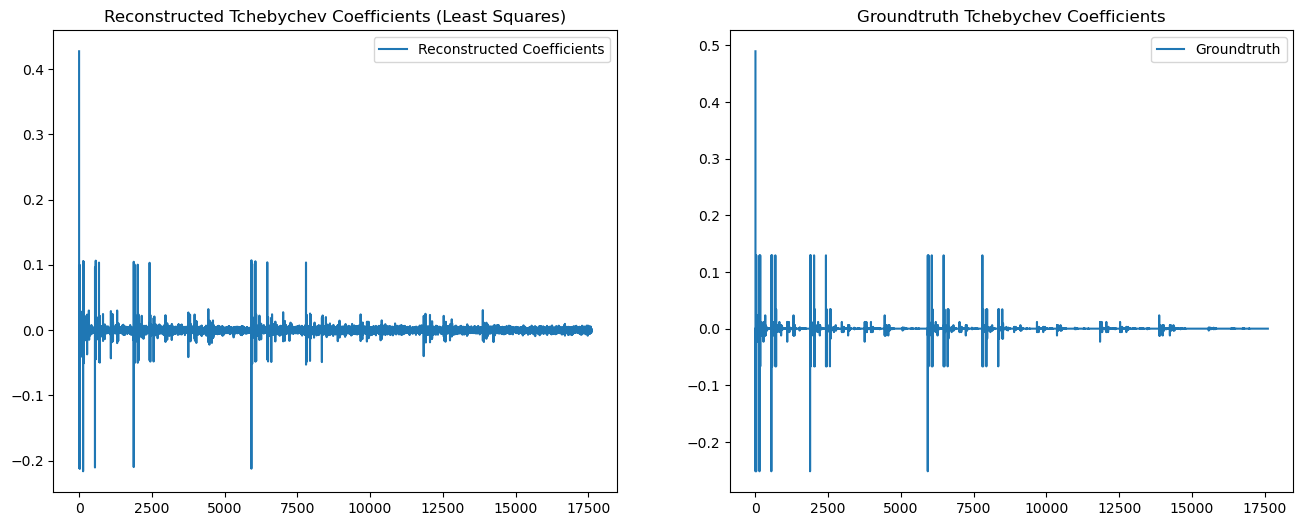

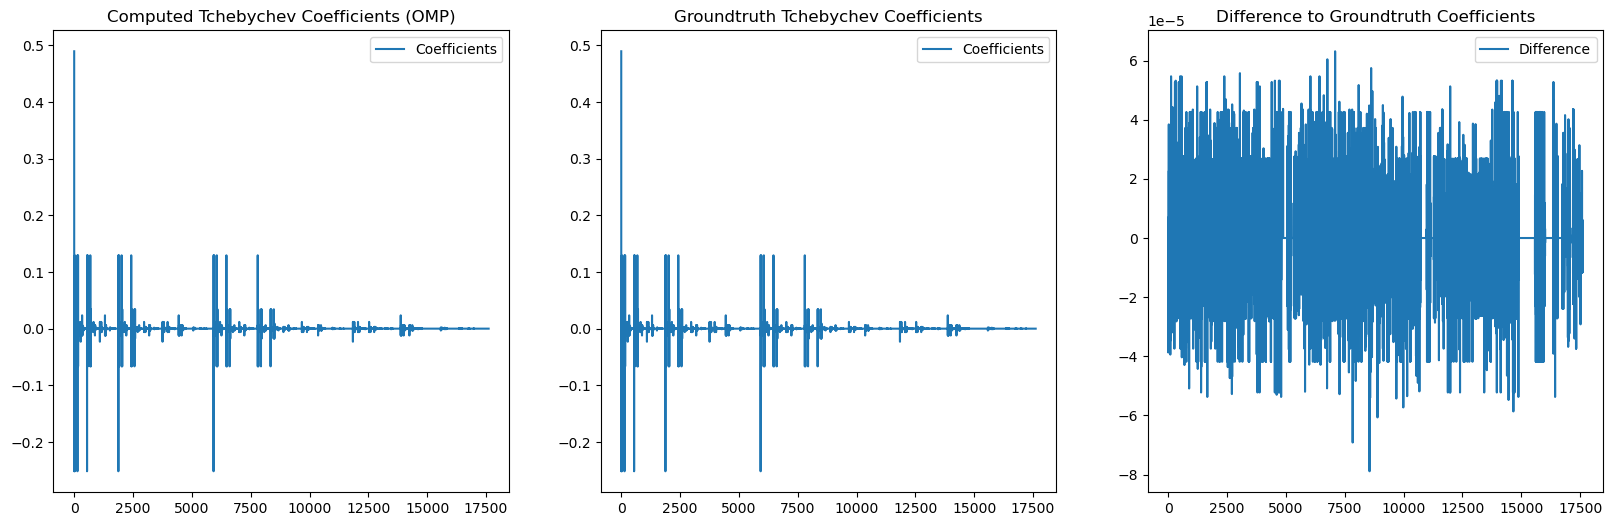

In [ ]:
# Here we generate the data
indices, samples, values, coeffs_gt, trunc_error = generate_data(
    15_000, 25, 6, device=device_id, dtype=dtype
)

# run OMP algorithm
start = time.time()
coeffs_rec, coeffs_lsr_rec, residuals = OMP.Tchebychev(
    samples,
    values,
    indices,
    num_iters=10000,
    lstsq_rec=True,
    tol=1e-3,
)

# some evaluation metrics (OMP)
print("Time to compute OMP solution is", time.time() - start, "seconds")
print("Final residual of OMP solution is", residuals[0].item())
print(
    "Relative reconstruction error of OMP solution:",
    (trunc_error + torch.linalg.norm(coeffs_gt - coeffs_rec)).item(),
)
print(
    "Number of nonzero entries of OMP solution (with tolerance 1e-5):",
    torch.sum(torch.abs(coeffs_rec) > 1e-5).item(),
)

# evaluation of some metrics (Least Squares)
print("Residual of least squares solution is", residuals[1].item())
print(
    "Relative reconstruction error of least squares solution is",
    (trunc_error + torch.linalg.norm(coeffs_gt - coeffs_lsr_rec)).item(),
)

# Plot least squares coefficients
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(coeffs_lsr_rec.cpu(), label="Reconstructed Coefficients")
plt.legend()
plt.title("Reconstructed Tchebychev Coefficients (Least Squares)")

plt.subplot(1, 2, 2)
plt.plot(coeffs_gt.cpu(), label="Groundtruth")
plt.legend()
plt.title("Groundtruth Tchebychev Coefficients")

# Plot OMP vs ground truth
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(coeffs_rec.cpu(), label="Coefficients")
plt.legend()
plt.title("Computed Tchebychev Coefficients (OMP)")

plt.subplot(1, 3, 2)
plt.plot(coeffs_gt.cpu(), label="Coefficients")
plt.legend()
plt.title("Groundtruth Tchebychev Coefficients")

plt.subplot(1, 3, 3)
plt.plot(coeffs_rec.cpu() - coeffs_gt.cpu(), label="Difference")
plt.legend()
plt.title("Difference to Groundtruth Coefficients")

In [14]:
print(torch.sum(coeffs_rec.abs() > 1e-5))

tensor(5000, device='cuda:0')
